In [1]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package gutenberg to /Users/ryan/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [2]:
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [4]:
#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])
print(emma_paras_tfidf[0:2])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()
X_test_tfidf_csr = X_test_tfidf.tocsr()

Number of features: 1948
  (0, 561)	0.526920649962092
  (0, 959)	0.849914483135525
  (1, 1859)	1.0


In [8]:
#number of paragraphs
n_train = X_train_tfidf_csr.shape[0]
n_test = X_test_tfidf_csr.shape[0]

In [9]:
#A list of dictionaries, one per paragraph
tfidf_bypara_train = [{} for _ in range(0,n_train)]
tfidf_bypara_test = [{} for _ in range(0,n_test)]

In [10]:
#List of features
terms = vectorizer.get_feature_names()

In [17]:
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara_train[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[8])
print('Tf_idf vector:', tfidf_bypara_train[8])

print('')
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara_test[i][terms[j]] = X_test_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_test[8])
print('Tf_idf vector:', tfidf_bypara_test[8])

Original sentence: Some laughed , and answered good - humouredly .
Tf_idf vector: {'answered': 0.6303993572313694, 'laughed': 0.6473670715665861, 'good': 0.4283836190303953}

Original sentence: Harriet , Mr . Elton , and Mr . Knightley , their own especial set , were the only persons invited to meet them ; the hours were to be early , as well as the numbers few ; Mr . Woodhouse ' s habits and inclination being consulted in every thing .
Tf_idf vector: {'consulted': 0.30864814233519644, 'numbers': 0.30864814233519644, 'persons': 0.2807656929772843, 'inclination': 0.25638335208192947, 'invited': 0.2644555056746491, 'meet': 0.2644555056746491, 'harriet': 0.14156350343485383, 'set': 0.23233483776150943, 'hours': 0.2880997364773336, 'elton': 0.15209627944728363, 'thing': 0.16679721730377428, 'knightley': 0.15075080715233527, 'habits': 0.30864814233519644, 'mr': 0.3348848049713026, 'early': 0.24390709981678624, 'woodhouse': 0.16563116837282985}


In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

In [19]:
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.201073044831475
Component 0:
" Oh !     0.999287
" Oh !     0.999287
" Oh !"    0.999287
" Oh !     0.999287
" Oh !     0.999287
" Oh !     0.999287
" Oh !     0.999287
" Oh !     0.999287
" Oh !     0.999287
" Oh !     0.999287
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.633795
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.593597
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.565785
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elt

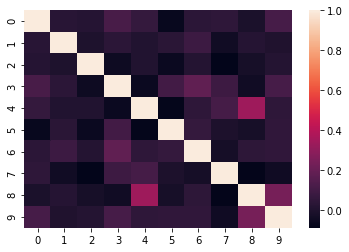

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [13]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

__Test Set__

In [20]:
# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 49.3570690135247
Component 0:
" Oh !    0.999919
" Oh !    0.999919
" Oh !    0.999919
" Oh !    0.999919
" Oh !    0.999919
" Oh !    0.999919
" Oh !    0.999919
" Oh !    0.999919
" Oh !    0.999919
" Oh !    0.999919
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.615747
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                                                  

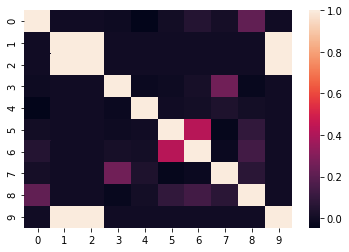

Key:
0 Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .
1 " Oh !
2 " Oh no , no !
3 Such was Jane Fairfax ' s history .
4 " That has been a good deal the case , my dear ; but not to the degree you mention .
5 " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
6 " And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !"
7 " You may well class the delight , the honour , and the comfo

In [22]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_test).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

In [25]:
%whos

Variable             Type                      Data/Info
--------------------------------------------------------
Normalizer           type                      <class 'sklearn.preprocessing.data.Normalizer'>
TfidfVectorizer      type                      <class 'sklearn.feature_e<...>on.text.TfidfVectorizer'>
TruncatedSVD         type                      <class 'sklearn.decomposi<...>ncated_svd.TruncatedSVD'>
X_test               list                      n=949
X_test_lsa           ndarray                   949x130: 123370 elems, type `float64`, 986960 bytes (963.828125 kb)
X_test_tfidf         csr_matrix                  (0, 555)	0.244727721514<...> 1141)	0.3842267127078686
X_test_tfidf_csr     csr_matrix                  (0, 555)	0.244727721514<...> 1141)	0.3842267127078686
X_train              list                      n=1422
X_train_lsa          ndarray                   1422x130: 184860 elems, type `float64`, 1478880 bytes (1.410369873046875 Mb)
X_train_tfidf        csr_matrix  